# Box

The goal of `freud` is to perform generic analyses of particle simulations.
Such simulations are always conducted within some region representing physical space; in `freud`, these regions are known as *simulation boxes*, or simply *boxes*.
An important characteristic of many simulations is that the simulation box is periodic, *i.e.* particles can travel and interact across system boundaries (for more information, see [the Wikipedia page](https://en.wikipedia.org/wiki/Periodic_boundary_conditions)).
Simulations frequently use periodic boundary conditions to effectively simulate infinite systems without actually having to include an infinite number of particles.
In such systems, a box in N dimensions can be represented by N linearly independent vectors.

The `Box` class provides the standard API for such simulation boxes throughout `freud`.
The class represents some 2- or 3-dimensional region of space, and it provides utility functions for interacting with this space, including the ability to wrap vectors outside this box into the box according to periodic boundary conditions.
Boxes are represented according to the [HOOMD-blue convention](https://hoomd-blue.readthedocs.io/en/stable/box.html) for boxes.
According to this convention, a 3D (2D) simulation box is fully defined by 3 (2) linearly independent vectors, which are represented by 3 (2) characteristic lengths and 3 (1) tilt factors indicating how these vectors are angled with respect to one another.
With this convention, a generic box is represented by the following $3\times3$ matrix:

$$\left(
    \begin{array}{ccc}
    L_x & xy \times L_x & xz \times L_z\\
    0   & L_y           & yz \times L_z\\
    0   & 0             & L_z\\
    \end{array}
\right)$$

where $xy$, $xz$, and $yz$ are the tilt factors.
Note that this convention imposes the requirement that the box vectors form a right-handed coordinate system, which manifests itself in the form of an upper (rather than lower) triangular box matrix.

In this notebook, we demonstrate the basic features of the `Box` class, particularly the facility for wrapping particles back into the box under periodic boundary conditions.
For more information, see the `freud.box` [documentation](https://freud.readthedocs.io/en/latest/box.html).

## Box Creation

There are many ways to construct a box.
We demonstrate all of these below, with some discussion of when they might be useful.

## Default (full) API

Boxes may be constructed explicitly using all arguments.
Such construction is useful when performing *ad hoc* analyses involving custom boxes.
In general, boxes are assumed to be 3D and [orthorhombic](https://en.wikipedia.org/wiki/Orthorhombic_crystal_system) unless otherwise specified.

In [1]:
import freud.box

# All of the below examples are valid boxes.
box = freud.box.Box(Lx=5, Ly=6, Lz=7, xy=0.5, xz=0.6, yz=0.7, is2D=False)
box = freud.box.Box(1, 3, 2, 0.3, 0.9)
box = freud.box.Box(5, 6, 7)
box = freud.box.Box(5, 6, is2D=True)
box = freud.box.Box(5, 6, xy=0.5, is2D=True)

## From a box object

The simplest case is simply constructing one freud box from another.

**Note that all forms of creating boxes aside from the explicit method above use methods defined within the Box class rather than attempting to overload the constructor itself.**

In [2]:
box = freud.box.Box(1, 2, 3)
box2 = freud.box.Box.from_box(box)
print("The original box: \n\t{}".format(box))
print("The copied box: \n\t{}\n".format(box2))

# Boxes are always copied by value, not by reference
box.Lx = 5
print("The original box is modified: \n\t{}".format(box))
print("The copied box is not: \n\t{}\n".format(box2))

# Note, however, that box assignment creates a new object that
# still points to the original box object, so modifications to
# one are visible on the other.
box3 = box2
print("The new copy: \n\t{}".format(box3))
box2.Lx = 2
print("The new copy after the original is modified: \n\t{}".format(box3))
print("The modified original box: \n\t{}".format(box2))

The original box: 
	Box(Lx=1.0, Ly=2.0, Lz=3.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)
The copied box: 
	Box(Lx=1.0, Ly=2.0, Lz=3.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)

The original box is modified: 
	Box(Lx=5.0, Ly=2.0, Lz=3.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)
The copied box is not: 
	Box(Lx=1.0, Ly=2.0, Lz=3.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)

The new copy: 
	Box(Lx=1.0, Ly=2.0, Lz=3.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)
The new copy after the original is modified: 
	Box(Lx=2.0, Ly=2.0, Lz=3.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)
The modified original box: 
	Box(Lx=2.0, Ly=2.0, Lz=3.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)


## From a matrix

A box can be constructed directly from the box matrix representation described above using the `Box.from_matrix` method.

In [3]:
# Matrix representation. Note that the box vectors must represent
# a right-handed coordinate system! This translates to requiring
# that the matrix be upper triangular.
box = freud.box.Box.from_matrix([[1, 1, 0], [0, 1, 0.5], [0, 0, 0.5]])
print("This is a 3D box from a matrix: \n\t{}\n".format(box))

# 2D box
box = freud.box.Box.from_matrix([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
print("This is a 2D box from a matrix: \n\t{}\n".format(box))

# Automatic matrix detection using from_box
box = freud.box.Box.from_box([[1, 1, 0], [0, 1, 0.5], [0, 0, 0.5]])
print("The box matrix was automatically detected: \n\t{}\n".format(box))

# Boxes can be numpy arrays as well
import numpy as np
box = freud.box.Box.from_box(np.array([[1, 1, 0], [0, 1, 0.5], [0, 0, 0.5]]))
print("Using a 3x3 numpy array: \n\t{}".format(box))

This is a 3D box from a matrix: 
	Box(Lx=1.0, Ly=1.0, Lz=0.5, xy=1.0, xz=0.0, yz=1.0, dimensions=3)

This is a 2D box from a matrix: 
	Box(Lx=1.0, Ly=1.0, Lz=0.0, xy=0.0, xz=0.0, yz=0.0, dimensions=2)

The box matrix was automatically detected: 
	Box(Lx=1.0, Ly=1.0, Lz=0.5, xy=1.0, xz=0.0, yz=1.0, dimensions=3)

Using a 3x3 numpy array: 
	Box(Lx=1.0, Ly=1.0, Lz=0.5, xy=1.0, xz=0.0, yz=1.0, dimensions=3)


## From a namedtuple or dict

A box can be also be constructed from a namedtuple with the appropriate entries.
Any other object that provides a similar API for attribute-based access of $L_x$, $L_y$, $L_z$, $xy$, $xz$, and $yz$ (or some subset) will work equally well.
This method is suitable for passing in box objects constructed by some other program, for example.

In [4]:
from collections import namedtuple
MyBox = namedtuple('mybox', ['Lx', 'Ly', 'Lz', 'xy', 'xz', 'yz', 'dimensions'])

box = freud.box.Box.from_box(MyBox(Lx=5, Ly=3, Lz=2, xy=0, xz=0, yz=0, dimensions=3))
print("Box from named tuple: \n\t{}\n".format(box))

box = freud.box.Box.from_box(MyBox(Lx=5, Ly=3, Lz=0, xy=0, xz=0, yz=0, dimensions=2))
print("2D Box from named tuple: \n\t{}".format(box))

Box from named tuple: 
	Box(Lx=5.0, Ly=3.0, Lz=2.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)

2D Box from named tuple: 
	Box(Lx=5.0, Ly=3.0, Lz=0.0, xy=0.0, xz=0.0, yz=0.0, dimensions=2)


Similarly, construction is also possible using any object that supports key-value indexing, such as a dict.

In [5]:
box = freud.box.Box.from_box(dict(Lx=5, Ly=3, Lz=2))
print("Box from dict: \n\t{}".format(box))

Box from dict: 
	Box(Lx=5.0, Ly=3.0, Lz=2.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)


## From a list

Finally, boxes can be constructed from any simple iterable that provides the elements in the correct order.

In [6]:
box = freud.box.Box.from_box((5, 6, 7, 0.5, 0, 0.5))
print("Box from tuple: \n\t{}\n".format(box))

box = freud.box.Box.from_box([5, 6])
print("2D Box from list: \n\t{}".format(box))

Box from tuple: 
	Box(Lx=5.0, Ly=6.0, Lz=7.0, xy=0.5, xz=0.0, yz=0.5, dimensions=3)

2D Box from list: 
	Box(Lx=5.0, Ly=6.0, Lz=0.0, xy=0.0, xz=0.0, yz=0.0, dimensions=2)


## Convenience APIs

We also provide convenience constructors for common geometries, namely square (2D) and cubic (3D) boxes.

In [7]:
cube_box = freud.box.Box.cube(L=5)
print("Cubic Box: \n\t{}\n".format(cube_box))

square_box = freud.box.Box.square(L=5)
print("Square Box: \n\t{}".format(square_box))

Cubic Box: 
	Box(Lx=5.0, Ly=5.0, Lz=5.0, xy=0.0, xz=0.0, yz=0.0, dimensions=3)

Square Box: 
	Box(Lx=5.0, Ly=5.0, Lz=0.0, xy=0.0, xz=0.0, yz=0.0, dimensions=2)


## Export

If you want to export or display the box, you can export box objects into their matrix or namedtuple representations, which provide completely specified descriptions of the box.
Note that the namedtuple type used by freud boxes, the BoxTuple, is simply an internal representation.

In [8]:
cube_box = freud.box.Box.cube(L=5)
cube_box.to_matrix()

[[5.0, 0.0, 0.0], [0, 5.0, 0.0], [0, 0, 5.0]]

In [9]:
cube_box.to_tuple()

BoxTuple(Lx=5.0, Ly=5.0, Lz=5.0, xy=0.0, xz=0.0, yz=0.0)

## Using boxes

Given a freud box object, you can query it for all its attributes.

In [10]:
box = freud.box.Box.from_matrix([[10, 0, 0], [0, 10, 0], [0, 0, 10]])
print("L_x = {}, L_y = {}, L_z = {}, xy = {}, xz = {}, yz = {}".format(
    box.Lx, box.Ly, box.Lz, box.xy, box.xz, box.yz))

print("The length vector: {}".format(box.L))
print("The inverse length vector: ({:1.2f}, {:1.2f}, {:1.2f})".format(*[L for L in box.Linv]))

L_x = 10.0, L_y = 10.0, L_z = 10.0, xy = 0.0, xz = 0.0, yz = 0.0
The length vector: (10.0, 10.0, 10.0)
The inverse length vector: (0.10, 0.10, 0.10)


Boxes also support converting to and from fractional coordinates.

**Note that the origin in real coordinates is defined at the center of the box.** This means the fractional coordinate range $[0, 1]$ maps onto $[-L/2, L/2]$, not $[0, L]$.

In [11]:
# Conversion to coordinate representation from fractions.
print(box.makeCoordinates([0, 0, 0]))
print(box.makeCoordinates([0.5, 0.5, 0.5]))
print(box.makeCoordinates([0.8, 0.3, 1]))
print()

# Conversion to and from coordinate representation, resulting
# in the input fractions.
print(box.makeFraction(box.makeCoordinates([0, 0, 0])))
print(box.makeFraction(box.makeCoordinates([0.5, 0.5, 0.5])))
print("[{:1.1f}, {:1.1f}, {:1.1f}]".format(*box.makeFraction(box.makeCoordinates([0.8, 0.3, 1]))))

[-5.0, -5.0, -5.0]
[0.0, 0.0, 0.0]
[3.0, -2.0, 5.0]

[0.0, 0.0, 0.0]
[0.5, 0.5, 0.5]
[0.8, 0.3, 1.0]


Finally (and most critically for enforcing periodicity), boxes support wrapping vectors from outside the box into the box.
The concept of periodicity and box wrapping is most easily demonstrated visually.

In [12]:
# We define box plot generation separately
from util import box_2d_to_points

# Construct the box and get points for plotting
Lx = Ly = 10
xy = 0.5
box = freud.box.Box.from_matrix([[Lx, xy*Ly, 0], [0, Ly, 0], [0, 0, 0]])
points = box_2d_to_points(box)

In [13]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(points[:, 0], points[:, 1], color='k')
plt.show()

<Figure size 900x600 with 1 Axes>

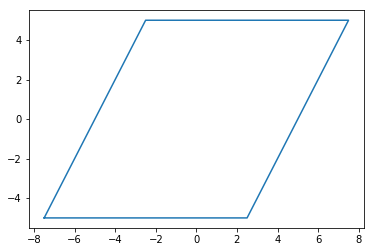

In [14]:
plt.figure()
plt.plot(points[:, 0], points[:, 1])
plt.show()

With periodic boundary conditions, what this actually represents is an infinite set of these boxes tiling space.
For example, you can locally picture this box as surrounding by a set of identical boxes.

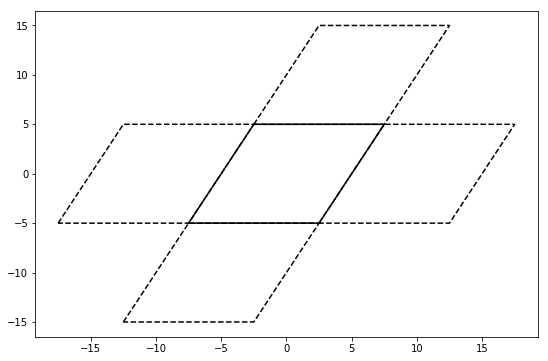

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(points[:, 0], points[:, 1], color='k')
ax.plot(points[:, 0] + Lx, points[:, 1], linestyle='dashed', color='k')
ax.plot(points[:, 0] - Lx, points[:, 1], linestyle='dashed', color='k')
ax.plot(points[:, 0] + xy*Ly, points[:, 1] + Ly, linestyle='dashed', color='k')
ax.plot(points[:, 0] - xy*Ly, points[:, 1] - Ly, linestyle='dashed', color='k')
plt.show()

Any particles in the original box will also therefore be seen as existing in all the neighboring boxes.

In [16]:
np.random.seed(0)
tmp = np.random.rand(5, 2)
origin = np.array(box.makeCoordinates([0, 0, 0]))
u = np.array(box.makeCoordinates([1, 0, 0])) - origin
v = np.array(box.makeCoordinates([0, 1, 0])) - origin
particles = u*tmp[:, [0]] + v*tmp[:, [1]]

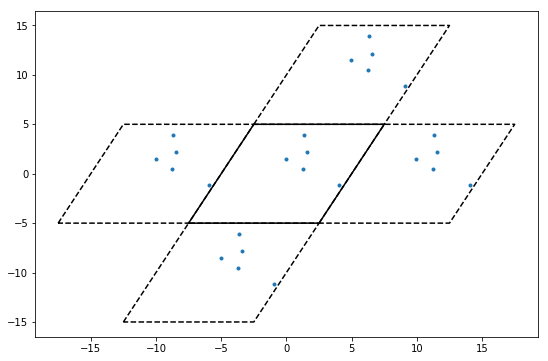

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the boxes.
ax.plot(points[:, 0], points[:, 1], color='k')
ax.plot(points[:, 0] + Lx, points[:, 1], linestyle='dashed', color='k')
ax.plot(points[:, 0] - Lx, points[:, 1], linestyle='dashed', color='k')
ax.plot(points[:, 0] + xy*Ly, points[:, 1] + Ly, linestyle='dashed', color='k')
ax.plot(points[:, 0] - xy*Ly, points[:, 1] - Ly, linestyle='dashed', color='k')

# Plot the points in the original box.
ax.plot(particles[:, 0] + origin[0], particles[:, 1] + origin[1],
        linestyle='None', marker='.', color='#1f77b4')

# Define the different origins.
origins = []
origins.append(np.array(box.makeCoordinates([-1, 0, 0])))
origins.append(np.array(box.makeCoordinates([1, 0, 0])))
origins.append(np.array(box.makeCoordinates([0, -1, 0])))
origins.append(np.array(box.makeCoordinates([0, 1, 0])))

# Plot particles in each of the periodic boxes.
for o in origins:
    ax.plot(particles[:, 0] + o[0], particles[:, 1] + o[1],
            linestyle='None', marker='.', color='#1f77b4')
plt.show()

Box wrapping takes points in the periodic images of a box, and brings them back into the original box.
In this context, that means that if we apply wrap to each of the sets of particles plotted above, they should all overlap.

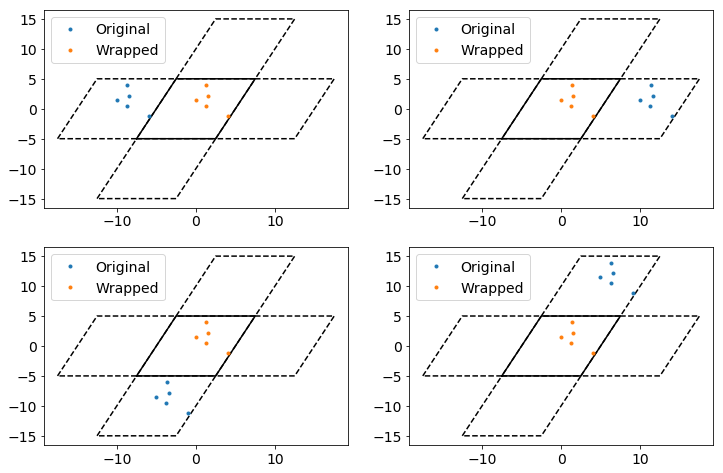

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the boxes.
for i, ax in enumerate(axes.flatten()):
    ax.plot(points[:, 0], points[:, 1], color='k')
    ax.plot(points[:, 0] + Lx, points[:, 1], linestyle='dashed', color='k')
    ax.plot(points[:, 0] - Lx, points[:, 1], linestyle='dashed', color='k')
    ax.plot(points[:, 0] + xy*Ly, points[:, 1] + Ly, linestyle='dashed', color='k')
    ax.plot(points[:, 0] - xy*Ly, points[:, 1] - Ly, linestyle='dashed', color='k')
    
    # Plot the points relative to origin i.
    o = origins[i]
    ax.plot(particles[:, 0] + o[0], particles[:, 1] + o[1],
            linestyle='None', marker='.', label='Original')
    
    # Now wrap these points and plot them.
    wrapped_particles = box.wrap(particles + o)
    ax.plot(wrapped_particles[:, 0], wrapped_particles[:, 1],
            linestyle='None', marker='.', label='Wrapped')
    ax.tick_params(axis="both", which="both", labelsize=14)

    ax.legend(fontsize=14)
plt.show()